# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [4]:
ylog=np.log1p(data_train_raw['loss'])
# ymean=ylog.mean()
# ystd=ylog.std()
ymean=ylog.min()
ystd=ylog.max()
data_train_raw['loss_g']=(ylog-ymean)/(ystd-ymean)

In [5]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: 0.64097862267
Std of log1py: 0.0724976841938
Lower clipping bound: 0.423485570089
Upper clipping bound: 0.858471675252
Shape of cleaned data: (187954, 133)


In [6]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

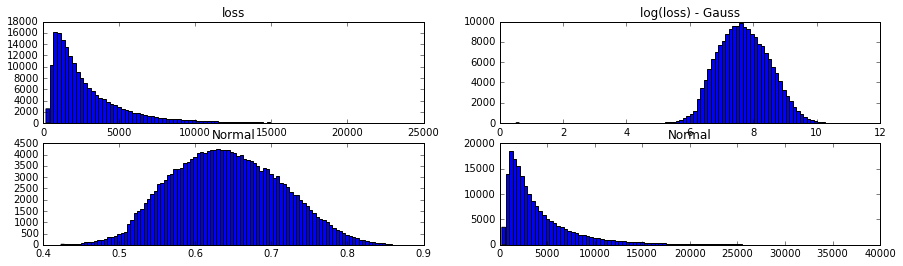

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - labeling encoder

In [8]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [9]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313500, 130)
(313500, 116) of which are categorical
(313500, 14) of which are continuous


In [10]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [11]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x
        
dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

KeyboardInterrupt: 

In [ ]:
features = dataCatAll.columns[98:]
dataCatAll_2 = dataCatAll[features]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll_2[feat] = pd.factorize(dataCatAll_2[feat], sort=True)[0]
dataCatAll_2.head()
# le.classes_

In [ ]:
dataCatAll = dataCatAll.drop(features,axis=1)
dataCatAll.head()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


In [ ]:
dataCatAll.head()

In [ ]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll_2 = mms.fit_transform(dataCatAll_2)

In [ ]:
print(x_catAll_2.shape)
x_catAll_2

# restore to x_trainDf and x_testDf - skipped

In [ ]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [81]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

# one-hot-encoding - skipped in order to keep the alphabetical order

In [82]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(313500, 275)


# split x_train and x_test

In [83]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:],x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# check the dimension of prepared data

In [84]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 307)
(187954, 307)
(187954,)


# splite the training data for valication

In [85]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(150363, 307)
(150363,)
(37591, 307)
(37591,)


In [86]:
del x_Train
del y_Train
del x_catAll
del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [87]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [88]:
testList = ['XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']

### Ridge Regression

In [89]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import Ridge

In [90]:
# cv = 3
# # alphas = (1e-2,1e-1,1,1e1,1e2)
# # alphas = (5,20,30,40)
# alphas = [10]
# regCV = RidgeCV(cv=cv,alphas = alphas)
# regCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(regCV.alpha_))
# # print('cv_values_: {}\n'.format(regCV.cv_values_))

In [91]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

In [92]:
# y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [93]:
# from sklearn.linear_model import LassoCV

In [94]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [95]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [96]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [97]:
# from sklearn.ensemble import RandomForestRegressor

In [98]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [99]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [100]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [101]:
import xgboost as xgb

In [102]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

In [105]:
num_round = 2000
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.155,'min_child_weight':1}# 1132, 75 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.15,'min_child_weight':1}# 1136, 75 rounds
# params = {'eval_metric':'mae','max_depth':12,'colsample_bytree':1,'alpha':1,'gamma':0.01,'eta':0.05,'min_child_weight':1}# 1136, 500 rounds
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,\
          'gamma':0.01,'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1124, 1450 rounds

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.109657	train-mae:0.109247
[1]	eval-mae:0.104679	train-mae:0.104279
[2]	eval-mae:0.100005	train-mae:0.099611
[3]	eval-mae:0.095633	train-mae:0.095236
[4]	eval-mae:0.091555	train-mae:0.091156
[5]	eval-mae:0.087758	train-mae:0.087352
[6]	eval-mae:0.084182	train-mae:0.083778
[7]	eval-mae:0.080863	train-mae:0.080462
[8]	eval-mae:0.077751	train-mae:0.077356
[9]	eval-mae:0.074865	train-mae:0.074472
[10]	eval-mae:0.072191	train-mae:0.071798
[11]	eval-mae:0.069689	train-mae:0.069299
[12]	eval-mae:0.067387	train-mae:0.066994
[13]	eval-mae:0.065229	train-mae:0.064834
[14]	eval-mae:0.063244	train-mae:0.062842
[15]	eval-mae:0.061393	train-mae:0.060992
[16]	eval-mae:0.059677	train-mae:0.059274
[17]	eval-mae:0.058088	train-mae:0.05768
[18]	eval-mae:0.056611	train-mae:0.056206
[19]	eval-mae:0.055253	train-mae:0.054844
[20]	eval-mae:0.053983	train-mae:0.053574
[21]	eval-mae:0.05282	train-mae:0.052412
[22]	eval-mae:0.051732	train-mae:0.051327
[23]	eval-mae:0.050737	train-mae:0.050335
[24]

In [106]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

1124.08926364


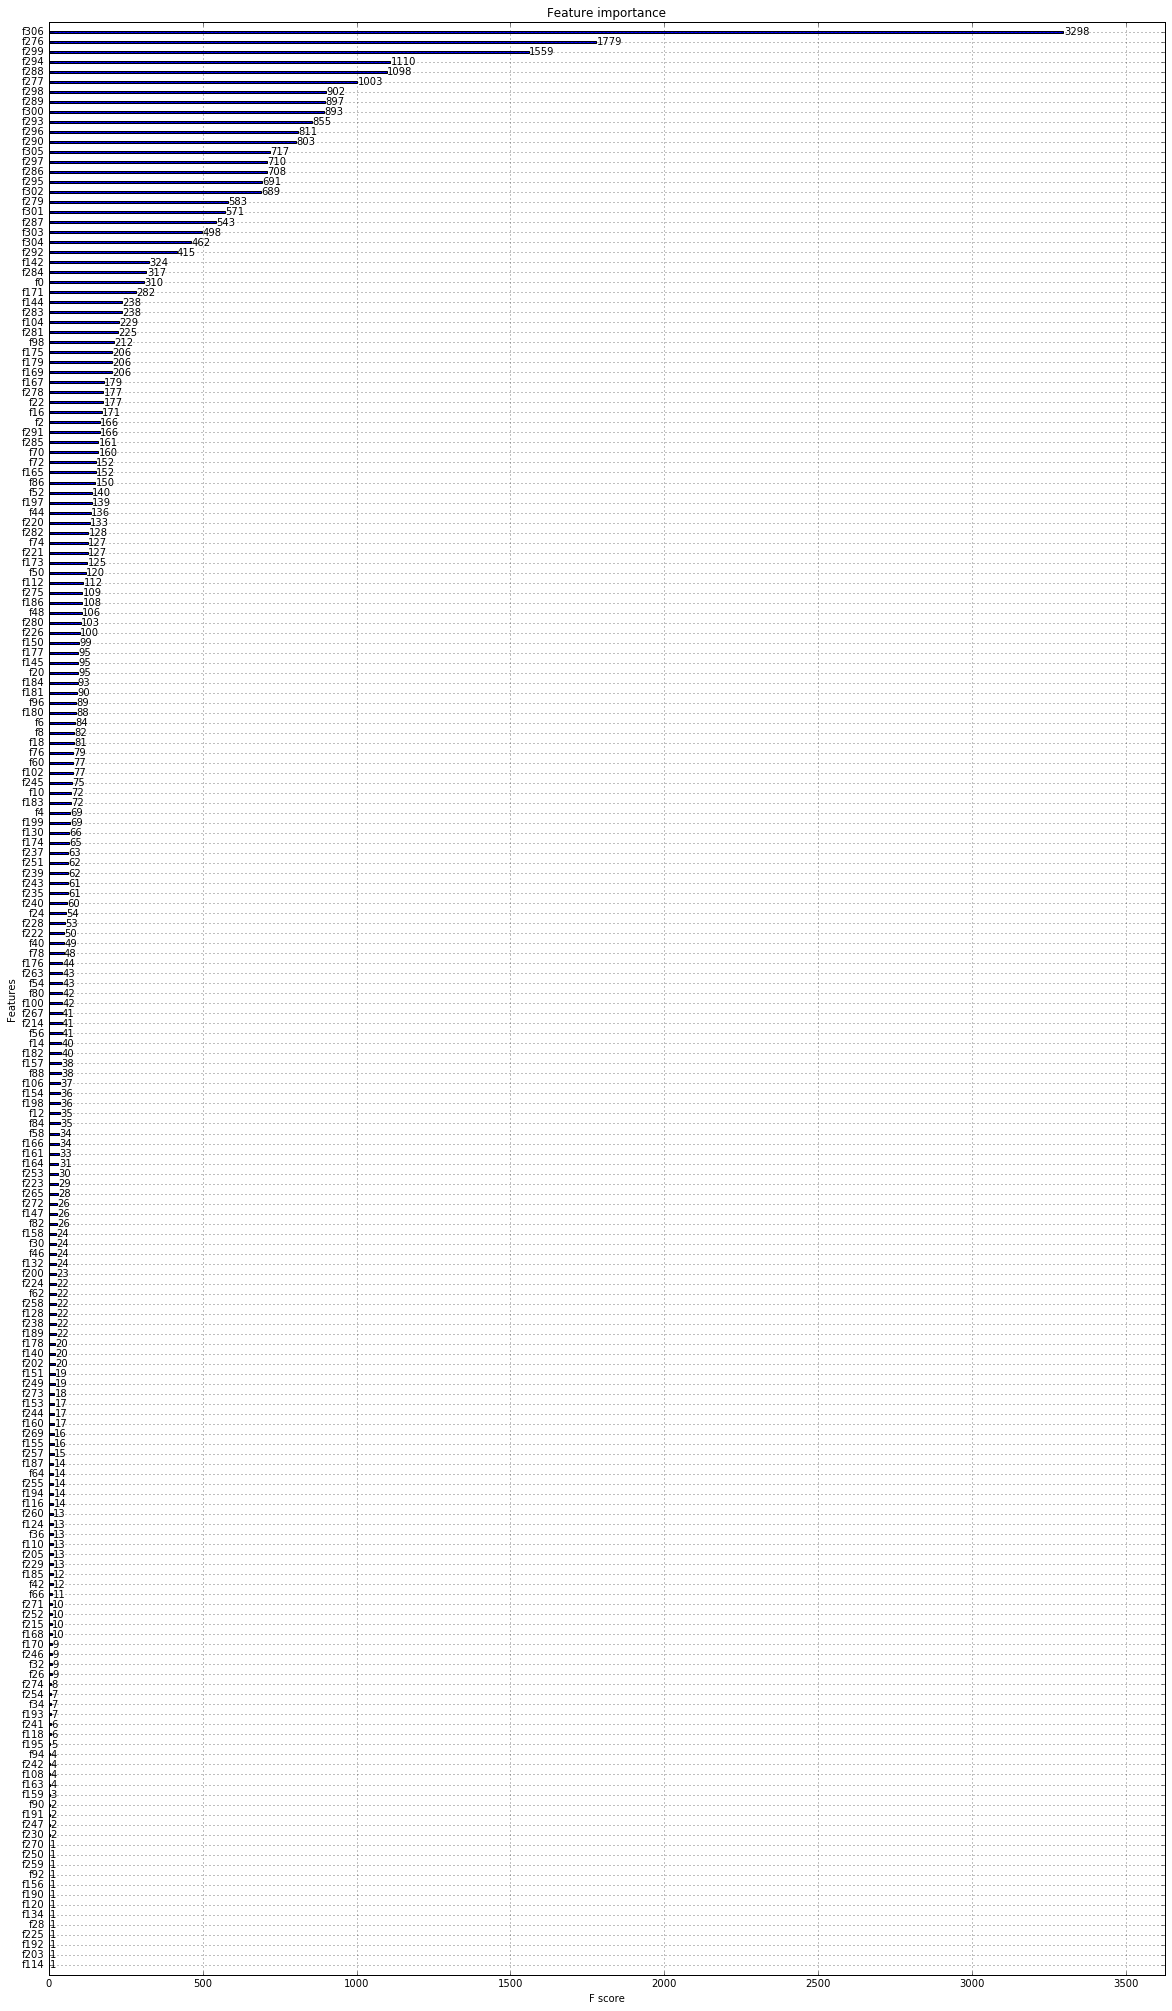

In [107]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() )

In [108]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [109]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [125]:
n_estimators = [7,15,30, 60, 90, 120]
# n_estimators = [10,20,30,40]
# n_estimators = [6]
base_estimator = Ridge(alpha = 40)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
    tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
    tmpAdReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        AdReg = tmpAdReg
        n_estimator = n_est
        err = err_i

1430.69006918
1460.51388655
1503.05418689


KeyboardInterrupt: 

In [ ]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

In [124]:
y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [113]:
# from sklearn.neighbors import KNeighborsRegressor

In [114]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [115]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [116]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [117]:
# from sklearn.svm import LinearSVR

In [118]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [119]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [120]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [121]:
from sklearn.neural_network import MLPRegressor

ImportError: cannot import name MLPRegressor

In [ ]:
MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
MLPReg.fit(x_train,y_train)

In [ ]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

In [ ]:
y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

# save files for submission

In [ ]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([regCV, gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models_data_on_raw_features.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

In [ ]:
testList
